This notebook shows some examples of ways to select and plot data from our analyses presented in ["Transcriptomic correlates of electrophysiological and morphological diversity within and across neuron types"](https://www.biorxiv.org/content/early/2019/01/18/524561).

We've written this mainly for people with little or no coding experience. You can start by using the code we already have written as a template, and fill in the gene names or ephys/morphology properties you're interested in learning more about. To run the code, highlight the cell you want and press Shift+Enter.

If you get lost, there's a [nice tutorial](https://mybinder.org/v2/gh/jvns/pandas-cookbook/master?filepath=cookbook%2FA%20quick%20tour%20of%20IPython%20Notebook.ipynb) on using Jupyter Notebook written by Julia Evans.

Please let me know if you find any issues with this notebook or have suggestions for how it could be improved! The goal was for this to be approachable and easy to use, so if you're confused that probably means I should have written it better. Please let me know! You can reach me at <claire.bomkamp@alumni.ubc.ca>.

# Setup

If you're running this notebook off of Binder, just run the cell below without changing anything.

Otherwise, make sure you have tables S4-S7. They should be saved as "TableS4.csv", "TableS5.csv", etc.  
Enter the path where you saved the files:

In [3]:
data_path = './Data/'

path_s4 = data_path + 'TableS4.csv'
path_s5 = data_path + 'TableS5.csv'
path_s6 = data_path + 'TableS6.csv'
path_s7 = data_path + 'TableS7.csv'

Run the next cell to load the data and get everything set up:  
- Import libraries  
- Load data
- Map between ephys/morphology property names and abbreviations
- Define functions for making scatter plots and fitting models 

In [4]:
print('importing libraries')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

matplotlib.style.use('seaborn-ticks')
color_exc = '#006DDB'
color_inh = '#920000'

print('loading data')
s4 = pd.read_csv(path_s4, index_col = 0)
s5 = pd.read_csv(path_s5, index_col = 0)
s6 = pd.read_csv(path_s6, index_col = 0, low_memory = False)
s7 = pd.read_csv(path_s7, index_col = 0, low_memory = False)

s6.index = [str(n) for n in s6.index]
s7.index = [str(n) for n in s7.index]

tmp = s5.drop_duplicates('gene_entrez_id')
tmp.index = tmp.gene_entrez_id.astype(str)
id_to_symbol = tmp.gene_symbol.to_dict()
symbol_to_id = {a:b for b,a in id_to_symbol.items()}

print('naming ephys/morphology properties')
property_labels = {'apamp': 'AP Amplitude', 'ahpamp': 'AHP Amplitude', 'aphw': 'AP Half-width', 
                   'maxfreq': 'Max Firing Frequency', 'tau' : 'Time Constant Tau', 'rmp': 'Resting Membrane Potential',
                   'avg_isi': 'Average Interspike Interval', 'f_i_curve_slope': 'Input-Output Curve Slope',
                   'cap' : 'Capacitance', 'sag': 'Sag', 'ri': 'Input Resistance', 'rheo': 'Rheobase',
                   'adratio': 'Adaptation Ratio', 'apthr': 'AP Threshold', 
                   'latency' : 'Latency', 'isi_cv' : 'ISI CoV', 
                   'average_bifurcation_angle_local' : 'Bifurcation Angle', 'max_branch_order' : 'Max Branch Order', 
                   'branchiness' : 'Branchiness', 'total_length' : 'Total Length',
                   'total_volume' : 'Total Volume', 'soma_surface' : 'Soma Surface'}

property_labels_units = {'apamp': 'AP Amplitude (mV)', 'ahpamp': 'AHP Amplitude (mV)', 'aphw': 'AP Half-width (ms)', 
                         'maxfreq': 'Max Firing\nFrequency (Hz)',
                         'tau' : 'Time Constant Tau (ms)', 'rmp': 'Resting Membrane Potential (mV)',
                         'avg_isi': 'Average Interspike Interval (ms)', 'f_i_curve_slope': 'Input-Output Curve\nSlope (Hz/pA)',
                         'cap' : 'Capacitance (pF)', 'sag': 'Sag', 'ri': u'Input Resistance (MΩ)', 'rheo': 'Rheobase (pA)',
                         'adratio': 'Adaptation Ratio', 'apthr': 'AP Threshold (mV)', 
                         'latency' : 'Latency (s)', 'isi_cv' : 'ISI CoV', 
                         'average_bifurcation_angle_local' : 'Bifurcation Angle (degrees)', 'max_branch_order' : 'Max Branch Order', 
                         'branchiness' : u'Branchiness\n(branches/μm)', 'total_length' : u'Total Length (μm)',
                         'total_volume' : u'Total Volume (μm^3)', 'soma_surface' : u'Soma Surface (μm^2)'}

props_morph = ['average_bifurcation_angle_local', 'branchiness', 'max_branch_order', 'total_length',
               'total_volume', 'soma_surface']
props_all = property_labels.keys()
props_ephys = list(set(props_all).difference(set(props_morph)))
property_table = pd.DataFrame(list(property_labels.keys()), list(property_labels.values()), columns = ['Abbreviation'])

print('defining functions')

def make_scatter(gene, prop, ax = None, zero_threshold = 2, alpha = 0.6, s = 30, log = False):

    # Set up axes
    if ax == None:
        fig, ax = plt.subplots()    
    if log:
        ax.set_yscale('log')

    # Select data
    if type(gene) == str:
        gene = str(symbol_to_id[gene])
    elif type(gene) == int:
        gene = str(gene)
    df = s7 if prop in props_morph else s6
    line_labels = [{'exc': 1, 'inh': 0}[line.split('__')[-1]] for line in df.columns]
    x = df.loc[gene]        
    y = df.loc[prop]
    line_labels_gene = line_labels
    exc = [n > 0.5 for n in line_labels]
    inh = [n <= 0.5 for n in line_labels]

    # Remove zero values if there are too many
    not_zero = [val > 0 for val in x]
    if not_zero.count(False) >= zero_threshold:
        x = x[not_zero]
        y = y[not_zero]
        exc = [a and b for a, b in zip(exc, not_zero)]
        inh = [a and b for a, b in zip(inh, not_zero)]
        line_labels_gene = [i for (i, v) in zip(line_labels_gene, not_zero) if v]

    # Plot
    x_exc = df.loc[:, exc].loc[gene]
    y_exc = df.loc[:, exc].loc[prop]    
    x_inh = df.loc[:, inh].loc[gene]
    y_inh = df.loc[:, inh].loc[prop]    
    
    fit_all = np.polyfit(x, np.log10(y) if log else y, deg = 1)
    fit_exc = np.polyfit(x_exc, np.log10(y_exc) if log else y_exc, deg = 1)
    fit_inh = np.polyfit(x_inh, np.log10(y_inh) if log else y_inh, deg = 1)
    

    # Draw lines of best fit
    lim_all = pd.Series([x.min(), x.max()])
    lim_exc = pd.Series([x_exc.min(), x_exc.max()])
    lim_inh = pd.Series([x_inh.min(), x_inh.max()])

    for lim, fit, linestyle in zip([lim_all, lim_exc, lim_inh], [fit_all, fit_exc, fit_inh], ['k--', 'k-', 'k-']):
        if log:
            fit_line = 10**(lim * fit[0] + fit[1])
        else:
            fit_line = lim * fit[0] + fit[1]
        ax.plot(lim, fit_line, linestyle, linewidth = 1)
        
    for x_subset, y_subset, color, marker in zip([x_inh, x_exc], [y_inh, y_exc], [color_inh, color_exc], ['o', 'D']):
        ax.scatter(x_subset, y_subset, color = color, s = s, marker = marker, alpha = alpha)
                
    ax.set_xlabel(id_to_symbol[gene] + ' ($log_2$ CPM+1)')
    ax.set_ylabel(property_labels_units[prop])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
def make_legend(ax, alpha = 0.6, s = 30):
    i = ax.scatter([], [], color = color_inh, marker = 'o', s = s, alpha = alpha)
    e = ax.scatter([], [], color = color_exc, marker = 'D', s = s, alpha = alpha)
    ax.legend([i, e], ['Inhibitory', 'Excitatory'], bbox_to_anchor=(1, 1), loc= 'upper left', frameon = True)


# fit linear models explaining ephys according to gene expression and/or cell class
# this is the same code as in the initial analysis, but modified to return the full models for a single 
    # combination of gene + property (as opposed to a summary table for many genes and properties)

def fit_models(gene, measure, df_input, zero_threshold = 2, min_samples = 10):

    if type(gene) == str:
        gene = symbol_to_id[gene]
    
    line_labels = [line.split('__')[-1] for line in df_input.columns]    
    gene = str(gene)    
    result_list = []
    output = []
    
    line_labels = pd.DataFrame(line_labels, index = df_input.columns[:len(line_labels)], columns = ['cell_class'])
    
    # Pull out data into x and y variables
    if (gene in df_input.index) & ((df_input.loc[gene] > 1).sum() >= min_samples):
        x = df_input.loc[gene, :]
        y = df_input.loc[measure, :]

        # If shapes of x and y make sense, create models
        if x.shape == (df_input.shape[1],) and y.shape == (df_input.shape[1],):

            # Remove all zero values if there are more than the specified threshold value                
            not_zero = [val > 0 for val in x]
            if not_zero.count(False) >= zero_threshold:
                x = x[not_zero]
                y = y[not_zero]
                line_labels_gene = line_labels[not_zero]
            else:
                line_labels_gene = line_labels

            if not_zero.count(True) >= min_samples:

                # Make a data frame with x and y data plus cell class
                df_int = pd.concat([x, y, line_labels_gene], axis = 1)
                gene_idx = 'Gene' + str(gene)
                df_int.rename(columns = {gene: gene_idx}, inplace = True)

                # Calculate models
                mod1 = smf.ols(formula = measure + ' ~ ' + ' +  ' + gene_idx, data = df_int)
                res1 = mod1.fit()
                output.append(res1)

                # run class-based models only if both cell types present
                if set(df_int['cell_class']) == {'exc', 'inh'}:
                    mod2 = smf.ols(formula = measure + ' ~ ' + 'C(cell_class)', data = df_int)
                    mod3 = smf.ols(formula = measure + ' ~ ' + gene_idx + ' + C(cell_class)', data = df_int)
                    mod4 = smf.ols(formula = measure + ' ~ ' + gene_idx + ' + C(cell_class) + ' + gene_idx + ' * C(cell_class)', data = df_int)
                    res2 = mod2.fit()
                    res3 = mod3.fit()
                    res4 = mod4.fit()
                    output.append(res2)
                    output.append(res3)
                    output.append(res4)

                    a1 = anova_lm(res2, res3)
                    a2 = anova_lm(res3, res4)
                    output.append(a1)
                    output.append(a2)

                    results = [measure, gene, 
                               res1.params[gene_idx], res3.params[gene_idx],  
                               res4.params[gene_idx], res4.params[gene_idx] + res4.params[gene_idx + ':C(cell_class)[T.inh]'], 
                               res1.pvalues[gene_idx], a1.loc[1, 'Pr(>F)'], a2.loc[1, 'Pr(>F)'], 
                               res1.aic, res2.aic, res3.aic, res4.aic]
                else:
                    print('gene is expressed in only one cell class: running class-independent model only')
                    results = [measure, gene, 
                               res1.params[gene_idx], np.nan, 
                               np.nan, np.nan, 
                               res1.pvalues[gene_idx], np.nan, np.nan, 
                               res1.aic, np.nan, np.nan, np.nan]
                    for n in range(5):
                        output.append(None)

                result_list.append(results)
    else:
        print('not enough cell types with expression > 1 log2(CPM + 1)')
    # Convert to dataframe
    df = pd.DataFrame(result_list, columns = ['ephys_measure', 'gene_entrez_id', 
                                              'beta_gene', 'beta_gene|class', 
                                              'slope_exc', 'slope_inh', 
                                              'pval_gene', 'pval_gene|class_anova', 'pval_int_anova', 
                                              'model1_aic', 'model2_aic', 'model3_aic', 'model4_aic'])
    output.append(df)
    return output
print('done!')

importing libraries
loading data
naming ephys/morphology properties
defining functions
done!


# View summary data from models
This next section of cells will allow you to select rows to view based on gene name, ephys/morphology property, significance level, etc.

You can use table S4 or S5 here. S4 includes only significant (FDR < 0.1 for either class-conditional or interaction models) results, and S5 includes all results. If filtering by number of significant properties for a given gene (last 3 cells in this section), you need to use S4.

First of all, we can get a sense of what our data looks like by viewing the first few rows:

In [5]:
s4.head()

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,n_significant_0.1_g|c,n_significant_0.1_int
41,rmp,69784,1500009L16Rik,0.708612,0.612558,0.499698,0.675691,0.000375,0.001475,0.645879,212.714190,218.085394,209.184115,210.951154,0.016377,0.064101,0.936128,8,4
53,rmp,73598,1700001O22Rik,-0.597760,-0.968526,-1.224694,-0.949696,0.025415,0.000119,0.766212,220.790624,218.085394,204.113465,206.015919,0.147982,0.020707,0.960526,11,1
235,rmp,373852,4833422C13Rik,1.439122,1.630314,0.972161,2.112861,0.003393,0.000281,0.175934,217.006899,218.085394,205.857019,205.836114,0.048998,0.030322,0.851402,4,0
251,rmp,100041734,4930522L14Rik,2.650137,2.394161,1.227781,2.631460,0.000011,0.000034,0.317438,205.704265,218.085394,201.580849,202.478079,0.002974,0.013717,0.876697,10,0
253,rmp,75833,4930532I03Rik,-1.979958,-1.919317,-2.328239,-1.797443,0.003323,0.002114,0.708880,216.967021,218.085394,209.896699,211.742891,0.048708,0.077723,0.944963,9,0


<b>Description of columns in Tables S4 and S5:</b>

- property: Ephys or morphology property  
- gene_entrez_id: Entrez Gene ID  
- gene_symbol : Official gene symbol  
- beta_gene: beta (slope) from the class-independent model  
- beta_gene|class: beta from the class-conditional model  
- slope_exc: excitatory cell type-specific slope from the interaction model  
- slope_inh: inhibitory cell type-specific slope from the interaction model  
- pval_gene: uncorrected p-value from the class-independent model       
- pval_gene|class_anova: uncorrected p-value from the class-conditional model  
- pval_int_anova: uncorrected p-value from the class-independent model    
- model1_aic: AIC (Akaike information criterion) goodness-of-fit measure, property ~ gene     
- model2_aic: AIC, property ~ cell class  
- model3_aic: AIC, property ~ gene + cell class  
- model4_aic: AIC, property ~ gene + cell class + gene * cell class interaction  
- FDR_gene: FDR-corrected p-value, class-independent (corresponds to pval_gene)  
- FDR_gene|class_anova: FDR-corrected p-value, class-conditional
- FDR_int_anova: FDR-corrected p-value, class-independent  
- n_significant_0.1_g|c: Total number of properties for which this gene shows FDR < 0.1 in the class-conditional model  (S4 only)  
- n_significant_0.1_int: Total number of properties for which this gene shows FDR < 0.1 in the interaction model (S4 only) 

Get all rows for your favorite gene:

In [6]:
s5[s5.gene_symbol == 'Camk2g']

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova
1606,rmp,12325,Camk2g,-0.951779,-0.782808,-1.604891,-0.645082,0.000263,9.629170e-03,0.249469,212.015703,218.085394,212.857483,213.394144,0.013972,0.159732,0.866612
13816,apthr,12325,Camk2g,0.253007,0.055039,0.428989,-0.007609,0.282158,8.439367e-01,0.587610,208.681015,207.008754,208.966954,210.642462,0.717392,0.977458,0.726039
26026,apamp,12325,Camk2g,0.269704,-2.700610,-1.089618,-2.970504,0.765115,7.737494e-04,0.384501,338.341056,314.281248,304.092731,305.258304,0.845138,0.010543,0.599772
38236,aphw,12325,Camk2g,-0.005550,-0.084852,-0.054788,-0.089888,0.790171,1.496866e-07,0.373349,-23.338795,-52.592272,-80.336906,-79.211302,0.854662,0.000022,0.710326
62656,ri,12325,Camk2g,-0.040887,-0.046468,-0.026071,-0.049886,0.000920,1.754548e-03,0.555914,-79.612378,-69.601584,-78.158843,-76.541522,0.015067,0.016226,0.978622
74866,tau,12325,Camk2g,0.021061,-0.021182,-0.004929,-0.023904,0.302215,3.366624e-01,0.764148,-25.936203,-36.370842,-35.366463,-33.465793,0.505417,0.690344,0.999761
87076,cap,12325,Camk2g,0.079360,0.028182,0.025018,0.028712,0.000155,1.450020e-01,0.946578,-30.506835,-48.314370,-48.605241,-46.610195,0.001221,0.358133,0.993239
99286,rheo,12325,Camk2g,0.060968,0.095604,-0.003141,0.112147,0.006359,2.773116e-04,0.095764,-20.676217,-12.980451,-25.232933,-26.294295,0.040674,0.004031,0.566967
111496,maxfreq,12325,Camk2g,0.027887,0.144821,0.025402,0.164827,0.388077,1.337542e-07,0.033371,18.311646,-1.543280,-29.522458,-32.516559,0.503873,0.000007,0.293185
123706,ahpamp,12325,Camk2g,0.006257,0.072957,0.050665,0.076691,0.712380,5.153611e-09,0.373800,-43.166090,-74.173752,-108.960155,-107.832902,0.792077,0.000003,0.552374


Properties can be specified using one of the following abbreviations:

In [7]:
property_table

,Abbreviation
Adaptation Ratio,adratio
Capacitance,cap
Soma Surface,soma_surface
Branchiness,branchiness
Rheobase,rheo
Bifurcation Angle,average_bifurcation_angle_local
Max Firing Frequency,maxfreq
Total Length,total_length
Total Volume,total_volume
AHP Amplitude,ahpamp


In [8]:
# Get the row for your favorite gene and ephys or morphology property

s5[(s5.gene_symbol == 'Camk2g') & (s5.property == 'ahpamp')]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova
123706,ahpamp,12325,Camk2g,0.006257,0.072957,0.050665,0.076691,0.71238,5.153611e-09,0.3738,-43.16609,-74.173752,-108.960155,-107.832902,0.792077,0.000003,0.552374


You can also specify the gene using its Entrez Gene ID <b>without quotes</b>:

In [9]:
s5[(s5.gene_entrez_id == 12325) & (s5.property == 'ahpamp')]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova
123706,ahpamp,12325,Camk2g,0.006257,0.072957,0.050665,0.076691,0.71238,5.153611e-09,0.3738,-43.16609,-74.173752,-108.960155,-107.832902,0.792077,0.000003,0.552374


Get all rows for a given gene below a certain significance threshold in the class-conditional model

In [10]:
s5[(s5.gene_symbol == 'Camk2g') & (s5['FDR_gene|class_anova'] < 0.001)]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova
38236,aphw,12325,Camk2g,-0.005550,-0.084852,-0.054788,-0.089888,0.790171,1.496866e-07,0.373349,-23.338795,-52.592272,-80.336906,-79.211302,0.854662,0.000022,0.710326
111496,maxfreq,12325,Camk2g,0.027887,0.144821,0.025402,0.164827,0.388077,1.337542e-07,0.033371,18.311646,-1.543280,-29.522458,-32.516559,0.503873,0.000007,0.293185
123706,ahpamp,12325,Camk2g,0.006257,0.072957,0.050665,0.076691,0.712380,5.153611e-09,0.373800,-43.166090,-74.173752,-108.960155,-107.832902,0.792077,0.000003,0.552374
148126,f_i_curve_slope,12325,Camk2g,0.037831,0.152106,0.011372,0.175684,0.239489,6.809575e-08,0.012933,17.535222,1.595023,-27.792218,-32.608190,0.339980,0.000003,0.179186
160336,avg_isi,12325,Camk2g,-0.008377,-0.108572,-0.022945,-0.122917,0.770158,1.144792e-05,0.112083,7.196977,-15.761871,-34.519657,-35.305092,0.847394,0.000415,0.618007


Same thing, but this time using the interaction model:

In [11]:
s5[(s5.gene_symbol == 'Man1c1') & (s5['FDR_int_anova'] < 0.05)]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova
30753,apamp,230815,Man1c1,-2.220099,-1.806848,2.401055,-2.294072,1.846146e-05,1.244835e-05,2.403332e-05,319.093948,314.281248,295.695813,278.019780,0.000286,0.000745,0.012754
104013,rheo,230815,Man1c1,0.067070,0.068691,-0.063979,0.084053,1.394250e-07,1.570625e-07,7.569039e-06,-42.059679,-12.980451,-40.624856,-60.730914,0.000039,0.000025,0.010991
128433,ahpamp,230815,Man1c1,0.042919,0.034255,-0.046628,0.043620,9.356138e-06,1.254342e-06,3.575607e-07,-63.730919,-74.173752,-97.499369,-124.072496,0.000098,0.000053,0.000443
140643,adratio,230815,Man1c1,0.038585,0.034475,-0.032178,0.042193,1.269670e-06,2.992421e-06,1.908663e-04,-84.676033,-70.842239,-92.367691,-105.720801,0.000089,0.000462,0.031063


Select only genes with a significant result in the class-conditional model but NOT the class-independent model  
Here we're using thresholds of < 0.01 and > 0.1, respectively  
Also in this example filtering by property

In [12]:
s5[(s5['FDR_gene|class_anova'] < 0.01) & (s5['FDR_gene'] > 0.1) & (s5.property == 'apthr')]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova
13206,apthr,214855,Arid5a,0.555482,1.042262,0.770737,1.052378,0.006686,0.000002,0.787625,202.143078,207.008754,184.702417,186.622340,0.274421,0.008349,0.865253
17809,apthr,382571,Kcnf1,-0.442278,-0.767748,-0.701428,-0.784897,0.003482,0.000001,0.809766,200.898156,207.008754,183.823533,185.759593,0.225082,0.008349,0.879463


You can also filter according to the number of properties a gene is associated with. This was calculated at a threshold of FDR < 0.1 in Table S4, for both class-conditional and interaction models.  

All genes uniquely associated with a single property (class-conditional):

In [13]:
s4[s4['n_significant_0.1_g|c'] == 1]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,n_significant_0.1_g|c,n_significant_0.1_int
1149,rmp,11928,Atp1a1,-0.959806,-1.001250,-2.027266,-0.817439,2.389484e-05,0.001484,0.143885,207.236142,218.085394,209.195333,208.838735,0.004291,0.064235,0.851126,1,0
3271,rmp,66366,Ergic3,2.408950,2.398989,1.652877,3.015125,4.017062e-05,0.002562,0.372562,208.276854,218.085394,210.276471,211.399191,0.005884,0.082959,0.885385,1,0
3623,rmp,72514,Fgfbp3,-1.748133,-1.654428,-1.578486,-1.695284,6.281292e-04,0.000499,0.901128,213.730209,218.085394,207.016425,208.999395,0.021543,0.039043,0.986603,1,0
3737,rmp,14337,Ftl2,2.246192,2.100935,1.441547,2.560410,3.786592e-05,0.002260,0.402248,208.158621,218.085394,210.029047,211.254936,0.005817,0.078280,0.891368,1,0
3967,rmp,19034,Gm10123,3.478585,3.249656,0.787209,3.772465,5.771987e-04,0.000567,0.198468,213.564248,218.085394,207.273074,207.448589,0.020547,0.041943,0.858847,1,0
4553,rmp,546015,Gm5905,3.708753,3.164402,2.058595,3.987934,9.077116e-05,0.003477,0.358027,209.904264,218.085394,210.877475,211.945359,0.008271,0.096919,0.881420,1,0
6323,rmp,67075,Magt1,1.399193,2.942856,3.498238,2.586623,9.043814e-02,0.000275,0.556685,223.035921,218.085394,205.814013,207.432826,0.295196,0.030275,0.920094,1,0
9808,rmp,11989,Slc7a3,0.828585,0.717890,0.865224,0.673761,2.169986e-05,0.000309,0.665579,207.042815,218.085394,206.049100,207.842971,0.004140,0.031666,0.940256,1,0
15134,apthr,319901,Dsel,-0.841323,-1.367161,-1.629244,-1.256342,5.530424e-03,0.000015,0.550568,201.782676,207.008754,188.755102,190.361971,0.259908,0.025514,0.696900,1,0
22917,apthr,69195,Tmem121,-1.774734,-1.704232,-1.478080,-1.886933,4.026214e-05,0.000072,0.607498,192.122915,207.008754,192.007722,193.716614,0.054622,0.062457,0.739892,1,0


That's a lot of genes; maybe we want to further filter by significance level:

In [14]:
s4[(s4['n_significant_0.1_g|c'] == 1) & (s4['FDR_gene|class_anova'] <= 0.001)]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,n_significant_0.1_g|c,n_significant_0.1_int
38669,aphw,108699,Chn1,0.045614,-0.128481,-0.059134,-0.136619,0.120667,0.000024,0.390205,-25.804809,-52.592272,-69.805016,-68.619627,0.217354,0.000647,0.721877,1,0
38946,aphw,235415,Cplx3,0.037240,0.031237,0.018855,0.039590,0.000141,0.000021,0.119881,-39.149371,-49.710627,-67.342936,-68.030211,0.001061,0.000596,0.517934,1,0
44376,aphw,241489,Pde11a,0.026623,0.057176,0.110321,0.057125,0.146771,0.000038,0.896054,-27.578676,-46.872002,-63.380694,-61.399810,0.251832,0.000859,0.962276,1,0
47512,aphw,244882,Tnfaip8l3,0.033665,0.057116,0.017195,0.060201,0.053799,0.000005,0.299783,-28.432169,-45.118741,-66.216272,-65.435669,0.116821,0.000223,0.667004,1,0
47525,aphw,21955,Tnnt1,0.037239,0.068097,1.038477,0.067508,0.065522,0.000012,0.065243,-26.159220,-36.584594,-55.977229,-57.911431,0.136430,0.000424,0.433034,1,0


Less stringent unique-ness threshold (fewer than 4 properties sharing a gene), more stringent significance threshold:

In [15]:
s4[(s4['n_significant_0.1_g|c'] < 4) & (s4['FDR_gene|class_anova'] <= 0.000001)]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,n_significant_0.1_g|c,n_significant_0.1_int
85847,cap,442803,A830005F24Rik,0.117982,0.157682,0.010755,0.162824,2.480841e-03,3.738218e-11,0.132254,-25.064546,-48.314370,-93.455477,-93.955432,1.043679e-02,1.140998e-07,0.626909,2,0
87881,cap,73720,Cst6,0.106096,0.101405,0.040414,0.108258,3.557553e-17,4.024911e-10,0.109604,-90.209953,-48.314370,-88.453420,-89.277808,4.343773e-13,6.652460e-07,0.592251,3,0
89586,cap,667373,Gm14446,0.139052,0.131944,0.045130,0.141591,2.514444e-05,6.300612e-10,0.086324,-34.130476,-48.314370,-87.511486,-88.756990,2.986514e-04,7.068112e-07,0.552698,2,0
91895,cap,17174,Masp1,0.059783,0.075373,0.017020,0.079994,2.250856e-03,3.545183e-10,0.075734,-22.829320,-44.071818,-84.695640,-86.199705,9.668826e-03,6.652460e-07,0.529313,3,0
95654,cap,20604,Sst,0.010791,0.027589,0.053356,0.027531,8.703206e-02,1.674555e-12,0.668420,-18.028665,-45.681865,-97.553335,-95.756668,1.661552e-01,6.814881e-09,0.943786,3,0


Filter for genes showing a highly significant interaction with exactly one property:

In [16]:
s4[(s4['n_significant_0.1_int'] == 1) & (s4['FDR_int_anova'] <= 0.001)]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova,n_significant_0.1_g|c,n_significant_0.1_int
91125,cap,67516,Kctd4,0.080400,0.056260,-0.009842,0.141676,3.608692e-08,0.001099,1.385426e-08,-45.746680,-38.779476,-48.422450,-82.561473,2.366107e-06,0.021497,0.000085,2,1
122987,ahpamp,74385,Ap5m1,0.040109,0.065896,-0.094000,0.093323,9.620841e-02,0.000088,1.256387e-06,-45.941730,-74.173752,-88.766289,-112.669982,1.691439e-01,0.000893,0.000723,9,1
124601,ahpamp,114886,Cygb,0.050528,0.028896,-0.054415,0.064434,3.940729e-08,0.023613,6.834340e-07,-74.838139,-74.173752,-77.698531,-102.894481,1.448057e-06,0.052821,0.000596,4,1
127144,ahpamp,231123,Haus3,-0.026935,0.057760,-0.088437,0.122604,3.475342e-01,0.015211,2.222299e-06,-43.953574,-74.173752,-78.527842,-101.223143,4.653353e-01,0.037708,0.000998,7,1
131763,ahpamp,20511,Slc1a2,-0.036704,-0.030291,0.037203,-0.039156,1.237791e-12,0.000002,5.931801e-07,-96.162335,-74.173752,-96.751835,-122.248684,8.843088e-10,0.000067,0.000596,10,1
90482,cap,14998,H2-DMa,0.111876,0.047534,-0.036779,0.202943,1.147409e-05,0.058550,7.522259e-08,-35.706619,-48.314370,-50.173244,-80.068544,1.646282e-04,0.220412,0.000306,0,1
131513,ahpamp,67815,Sec14l2,-0.020391,0.029502,-0.052503,0.092658,3.585283e-01,0.064305,7.097398e-08,-40.608505,-77.472190,-79.182983,-109.421293,4.770219e-01,0.115203,0.000173,3,1


# Scatter plots
Create scatter plots for one or more combinations of gene + ephys or morphology property


Changing "zero_threshold" sets a threshold for how many cell types are allowed with zero expression of the gene. If there are more zeroes than the threshold, cell types with zero expression will be removed.  
You can change this values for plotting purposes, but the correlations in S4 and S5 were all calculated using a threshold of 2 (which is the default for the scatter plot function).

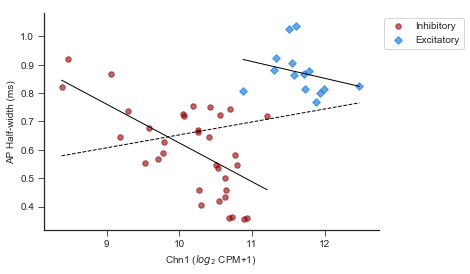

In [17]:
# Scatter plot for a single gene and property
# This example of one of the highly significant, unique genes from a couple of examples above

gene = 'Chn1'
measure = 'aphw'

make_scatter(gene, measure)
make_legend(plt.gca())

plt.show()

<b>Customizing the scatter plot</b>  
alpha: Transparency of the points (0 to 1, default is 0.6)  
s: Size of the points (default is 30)  
log: plot on log scale (True) or linear (False; default)  

The line starting with "fig, ax..." allows you to set the figure size.

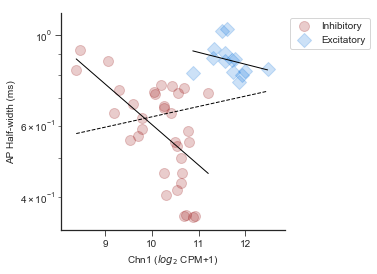

In [18]:
gene = 'Chn1'
measure = 'aphw'
fig, ax = plt.subplots(figsize = (4, 4))
make_scatter(gene, measure, ax, alpha = 0.2, s = 100, log = True)
make_legend(ax, alpha = 0.2, s = 100)
plt.show()

You can also enter the gene using its Entrez ID <b>(without quotes)</b>

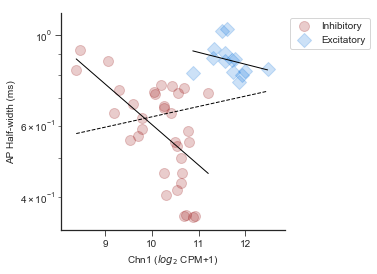

In [19]:
gene = 108699
measure = 'aphw'
fig, ax = plt.subplots(figsize = (4, 4))
make_scatter(gene, measure, ax, alpha = 0.2, s = 100, log = True)
make_legend(ax, alpha = 0.2, s = 100)
plt.show()

# Plotting multiple genes on a grid
You might want to visualize several gene/property relationships at once. The following shows several examples of how you can specify one gene + several properties or vice versa, or several of each.  

Run the cell with the genes + properties you want, then skip to the plotting cell at the end of this section (don't run the cells in between; you will end up plotting just the genes + properties from the last cell you ran).

Plot one gene against several properties:

In [20]:
genes = 'Lrrk2'
measures = props_morph

"props_morph", "props_ephys", and "props_all" (<b>without quotes</b>) will let you plot every property in a given category. Or specify the exact properties you want (see table above):

In [21]:
genes = 'Chn1'
measures = ['aphw', 'ahpamp', 'ri', 'rheo', 'adratio', 'apamp', 'maxfreq', 'avg_isi']

Plot several genes against one property:

In [22]:
genes = ['BC048546', 'Pcdh9', 'Bach1', 'Tubb5', 'Fxyd6', 'Slc8a2']
measures = 'ahpamp'

Plot several genes against several different properties - in this case ahpamp for the first 3, then aphw for the next 3

The number of genes should match the number of properties (including repeats):

In [23]:
genes = ['BC048546', 'Pcdh9', 'Bach1', 'Tubb5', 'Fxyd6', 'Slc8a2']
measures = ['ahpamp'] * 3 + ['aphw'] * 3

For more flexibility, this could also be written as:

In [24]:
genes = ['BC048546', 'Pcdh9', 'Bach1', 'Tubb5', 'Fxyd6', 'Slc8a2']
measures = ['ahpamp', 'ahpamp', 'ahpamp', 'aphw', 'aphw', 'aphw']

You can also pick genes to plot according to some combination of significance thresholds (similar to how we selected rows in the previous section).  
Be careful; you probably don't want to plot 1000 genes at once. Here we've set a threshold so that we only plot the top 25 genes if there are more than that.

In this case, we're looking for genes that are 1) highly significant in the class-conditional model and 2) non-significant in the interaction model for the property AHP amplitude.

In [25]:
measures = 'ahpamp'
genes = list(s5[(s5['FDR_gene|class_anova'] < 0.00001) &      # Only pick rows where FDR < 0.000001
                (s5['FDR_int_anova'] > 0.1) &                 # Only pick rows where FDR_int > 0.1
                (s5.property == measures)]['gene_symbol'])    # Only pick rows where the property is ahpamp

print('Total genes: ', len(genes))
threshold = 25
if len(genes) > threshold:
    genes = genes[:threshold]

Total genes:  98


Similar to above example, but not limited to one property

Also limiting to only relationships with negative slopes (class-conditional as well as class-specific slopes)

In [26]:
rows = s5[(s5['FDR_gene|class_anova'] < 0.000001) & 
          (s5['beta_gene|class'] < 0) &
          (s5['slope_exc'] < 0) &
          (s5['slope_inh'] < 0) &
          (s5['FDR_int_anova'] > 0.1)]
genes = list(rows['gene_symbol'])
measures = list(rows['property'])

print('Total genes: ', len(genes))
threshold = 25
if len(genes) > threshold:
    genes = genes[:threshold]
    measures = measures[:threshold]

Total genes:  52


Relationships with a significant interaction term, where the slopes in E and I types are different (ie, there might actually be an opposite relationship, as opposed to just no relationship in one class)

As you can see from the plots, this is just a very coarse way of filtering; one class can have a strong slope and the other can have a very weak slope in the opposite direction.

In [27]:
rows = s5[(np.sign(s5['slope_exc']) != np.sign(s5['slope_inh'])) &  # Only pick rows where signs of slope_exc and slope_inh do not match 
          (s5['FDR_int_anova'] < 0.001)]
genes = list(rows['gene_symbol'])
measures = list(rows['property'])

print('Total genes: ', len(genes))
threshold = 25
if len(genes) > threshold:
    genes = genes[:threshold]
    measures = measures[:threshold]

Total genes:  45


Running one of the 3 cells directly above just sets the values of "genes" and "measures" according to the criteria specified. We can check the output before plotting:

In [28]:
print(genes)
print(measures)

['Hes1', 'Galnt14', 'Gm336', 'Hes1', 'Rims3', 'Gm6788', 'Kcns1', 'Rasl10a', 'Ankrd35', 'Gstm5', 'H2-DMa', 'Kctd4', 'Rora', 'S100a6', 'Sema4a', 'Slc8a2', '2300009A05Rik', 'Ap5m1', 'Arl15', 'Atp6v1g2', 'Cadm4', 'Coa7', 'Cygb', 'Dok5', 'Eno1']
['apamp', 'ri', 'ri', 'ri', 'ri', 'tau', 'tau', 'tau', 'cap', 'cap', 'cap', 'cap', 'cap', 'cap', 'cap', 'maxfreq', 'ahpamp', 'ahpamp', 'ahpamp', 'ahpamp', 'ahpamp', 'ahpamp', 'ahpamp', 'ahpamp', 'ahpamp']


# Run this cell to plot:

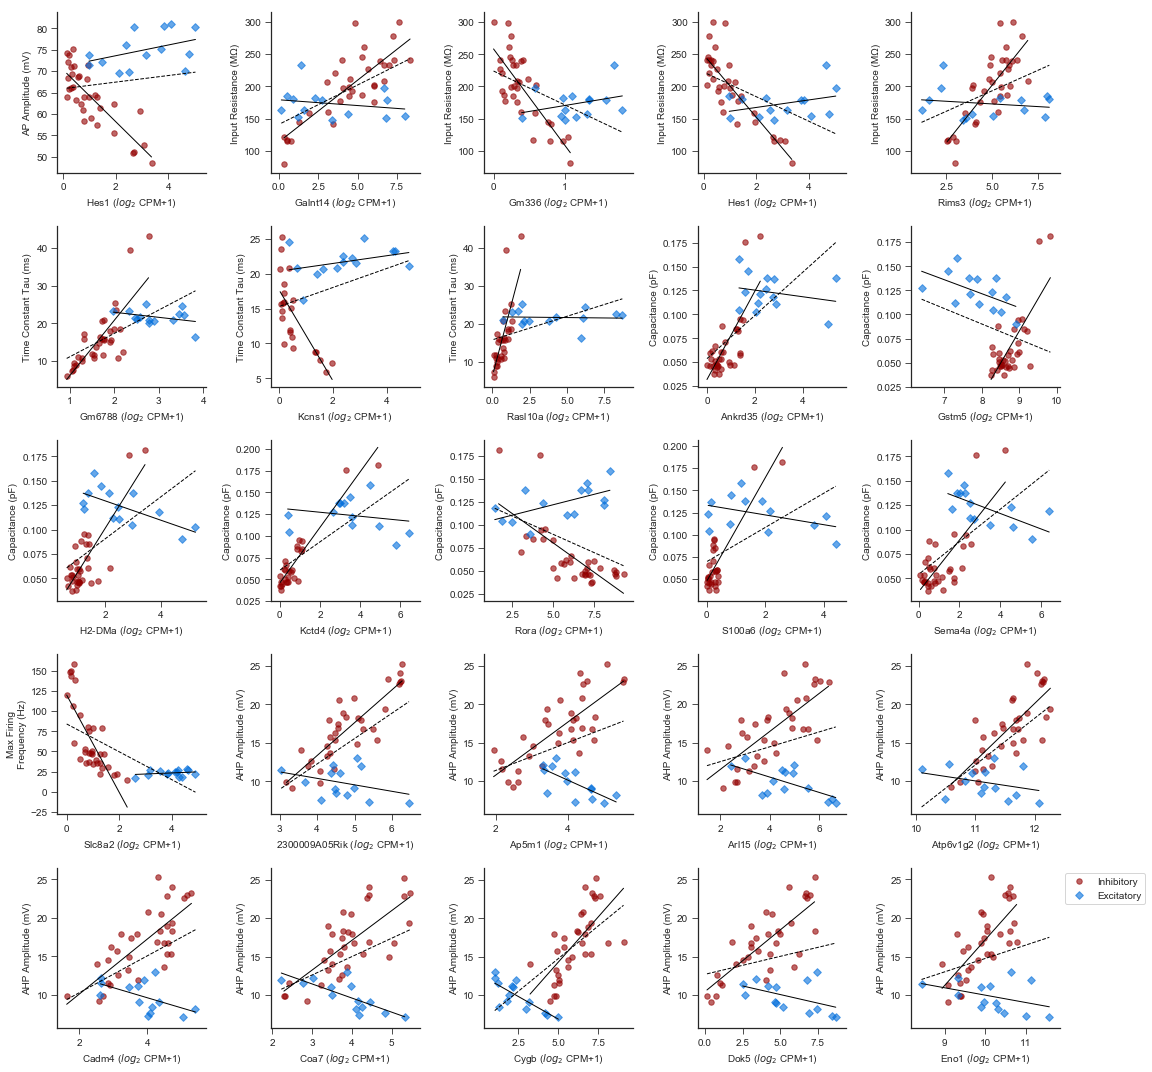

In [29]:
if (type(genes) != list) & (type(measures) == list):
    genes = [genes] * len(measures)
elif (type(measures) != list) & (type(genes) == list):
    measures = [measures] * len(genes)
elif (type(measures) != list) & (type(genes) != list):
    print('Either "genes" or "measures" needs to be provided as a list')
    print('For example:\ngenes = ["BC048546", "Pcdh9", "Bach1"]')

# Set up axes
xy = int(math.ceil(np.sqrt(len(genes))))
fig, axes = plt.subplots(xy, xy, figsize = (xy * 3, xy * 3))
# This will automatically pick the number of axes and the figure size
# If you want to set this yourself, you can do something like this (remove # to run the line below):
# fig, axes = plt.subplots(2, 3, figsize = (8, 6))

for gene, measure, ax in zip(genes, measures, axes.flat):
    make_scatter(gene, measure, ax)
make_legend(ax)
for ax in axes.flat[len(genes):]:
    ax.axis('off')   
fig.tight_layout()


plt.show()

# See the full model output for a gene + property

If you want to see the full model results rather than just the summary data in Tables S4 and S5, you can re-run the models for a specific gene/property pair.

Enter your gene of interest and ephys/morphology property


In [30]:
measure = 'rmp'
gene = 'Camk2g'

This will give some warnings on the ANOVA step. This seems to not be an actual problem, just an issue with how statsmodels handles warnings:

https://github.com/statsmodels/statsmodels/issues/4974

In [31]:
output = fit_models(gene, measure, s6)

//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


The properties 'total_length', 'cap', 'latency', 'max_branch_order', 'total_volume', 'f_i_curve_slope', 'rheo', 'maxfreq', 'adratio', 'ri', 'branchiness', 'isi_cv', 'avg_isi', 'tau', 'sag', and 'ahpamp' were log10-transformed before running models. You can run the models with or without, but they will match our data only if you use the log transform.

Add "_log10" to the property name in order to use the log-transformed values.

In [32]:
gene = 'Lrrk2'
measure = 'branchiness_log10'

Use the data from Table S6 for ephys properties and Table S7 for morphological properties

In [33]:
output = fit_models(gene, measure, s7)

//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
//anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [34]:
res1, res2, res3, res4, a1, a2, df = output

Check whether your summary results match those in Table S5

Summary table from the models you just ran:

In [35]:
df

,ephys_measure,gene_entrez_id,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic
0,branchiness_log10,66725,0.014206,0.042786,0.041847,0.045651,0.11168,0.000134,0.873661,-88.737999,-88.186658,-102.056228,-100.084465


The corresponding slice from Table S5:

In [36]:
s5[(s5.gene_symbol == gene) & (s5.property == measure.replace('_log10', ''))]

,property,gene_entrez_id,gene_symbol,beta_gene,beta_gene|class,slope_exc,slope_inh,pval_gene,pval_gene|class_anova,pval_int_anova,model1_aic,model2_aic,model3_aic,model4_aic,FDR_gene,FDR_gene|class_anova,FDR_int_anova
30385,branchiness,66725,Lrrk2,0.014206,0.042786,0.041847,0.045651,0.11168,0.000134,0.873661,-88.737999,-88.186658,-102.056228,-100.084465,0.401241,0.046364,0.946519


View the complete model outputs

In [37]:
# class-independent model (property~gene)

res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      branchiness_log10   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.643
Date:                Wed, 23 Jan 2019   Prob (F-statistic):              0.112
Time:                        11:14:30   Log-Likelihood:                 46.369
No. Observations:                  43   AIC:                            -88.74
Df Residuals:                      41   BIC:                            -85.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7447      0.029    -59.207      0.000      -1.804      -1.685
Gene66725      0.0142      0.009      1.626      0.112      -0.003       0.032
==============================================================================
Omnibus:                        6.694   Durbin-Watson:                   2.257
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                5.939
Skew:                           0.615   Prob(JB):                       0.0513
Kurtosis:                       4.342   Cond. No.                         8.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# property ~ class

res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      branchiness_log10   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.087
Date:                Wed, 23 Jan 2019   Prob (F-statistic):              0.156
Time:                        11:14:30   Log-Likelihood:                 46.093
No. Observations:                  43   AIC:                            -88.19
Df Residuals:                      41   BIC:                            -84.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.7300      0.024    -73.528      0.000      -1.778      -1.682
C(cell_class)[T.inh]     0.0407      0.028      1.445      0.156      -0.016       0.098
==============================================================================
Omnibus:                        3.162   Durbin-Watson:                   2.346
Prob(Omnibus):                  0.206   Jarque-Bera (JB):                2.026
Skew:                           0.422   Prob(JB):                        0.363
Kurtosis:                       3.648   Cond. No.                         3.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# Class-conditional model (property ~ gene + class)

res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      branchiness_log10   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     10.40
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           0.000231
Time:                        11:14:30   Log-Likelihood:                 54.028
No. Observations:                  43   AIC:                            -102.1
Df Residuals:                      40   BIC:                            -96.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.9251      0.050    -38.323      0.000      -2.027      -1.824
C(cell_class)[T.inh]     0.1342      0.032      4.137      0.000       0.069       0.200
Gene66725                0.0428      0.010      4.226      0.000       0.022       0.063
==============================================================================
Omnibus:                        5.924   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.538
Skew:                           0.478   Prob(JB):                       0.0627
Kurtosis:                       4.475   Cond. No.                         19.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# Interaction model (property ~ gene + class + gene*class)

res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      branchiness_log10   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     6.773
Date:                Wed, 23 Jan 2019   Prob (F-statistic):           0.000872
Time:                        11:14:30   Log-Likelihood:                 54.042
No. Observations:                  43   AIC:                            -100.1
Df Residuals:                      39   BIC:                            -93.04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.9208      0.057    -33.423      0.000      -2.037      -1.805
C(cell_class)[T.inh]               0.1231      0.077      1.606      0.116      -0.032       0.278
Gene66725                          0.0418      0.012      3.542      0.001       0.018       0.066
Gene66725:C(cell_class)[T.inh]     0.0038      0.024      0.160      0.874      -0.044       0.052
==============================================================================
Omnibus:                        5.466   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                4.952
Skew:                           0.444   Prob(JB):                       0.0841
Kurtosis:                       4.406   Cond. No.                         32.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# We presented the class-conditional model in the manuscript in terms of the effects of the gene on the property
    # after removing the effects of class (property ~ gene | class)
# This was done by comparing the model above with the property ~ class model using an ANOVA

a1

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,41.0,0.295067,0.0,NaN,NaN,NaN
1,40.0,0.204005,1.0,0.091062,17.854962,0.000134


In [42]:
# The class-conditional model is similar: We used an ANOVA to isolate just the interaction effect

a2

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,40.0,0.204005,0.0,NaN,NaN,NaN
1,39.0,0.203871,1.0,0.000134,0.025619,0.873661
